<center><img src = "practicals/Images/ATU_Logo.jpg"></center>

<h2 style="color: #001a79;">Author: Sam Tracey</h2>
<h2 style="color: #001a79;">Student ID: G00398245</h2>
<h2 style="color: #001a79;">Topic: <a href="https://keras.io/examples/timeseries/timeseries_anomaly_detection/">Timeseries anomaly detection using an Autoencoder</a></h2>
<hr style="border-top: 1px solid #001a79;" />



<h2 style="color: #001a79;">Introduction</h2>

<p style="color: #001a79;"> Keras is a high-level neural networks API, written in Python and capable of running on top of TensorFlow, CNTK, or Theano. It was developed with a focus on enabling fast experimentation. Being able to go from idea to result with the least possible delay is key to doing good research. </p>


<hr style="border-top: 1px solid #001a79;" />



In [1]:
# Python package to facilitate working with arrays.
import numpy as np

# Python package for data analysis and manipulation using dataframes.
import pandas as pd

# High level neural network API.
import tensorflow.keras as keras

# The original Keras tutorial imported layers from keras.layers.
# As this is only used in one cell (model = keras.Sequential) we will not import it here.
# Instead we will use keras.layers in the cell.

# Python package for data visualization.
import matplotlib.pyplot as plt

<h2 style="color: #001a79;">Data</h2>

<p style="color: #001a79;">The Numenta Anomaly Benchmark (NAB) is a novel benchmark for evaluating algorithms for anomaly detection. in streaming / real-time applications.<br>
There are two distinct data categories that benchmark scripts can be assessed against:<br><br>
- Real Data. Which is data collected from sources such as Amazon AWS, Ad Exchange or Twitter.<br>
- Artificial Data. Synthetic data that has been generated manually.<br><br>
This notebook uses The Artificial Datasets <code>art_daily_small_noise.csv</code> and <code>art_daily_jumpsup.csv</code>.<br><br>
More information about the NAB Benchmark and the data sets involved can be found at the links below. </p>


<hr style="border-top: 1px solid #001a79;" />



https://www.kaggle.com/datasets/boltzmannbrain/nab

https://github.com/numenta/NAB

In [2]:
# Root of URLs.
root_url = 'https://raw.githubusercontent.com/numenta/NAB/master/data/'

# Data file without anomaly.
no_anomaly_url = root_url + 'artificialNoAnomaly/art_daily_small_noise.csv'

# Data file with anomaly.
with_anomaly_url = root_url + 'artificialWithAnomaly/art_daily_jumpsup.csv'

In [3]:
# 
df_small_noise = pd.read_csv(no_anomaly_url, parse_dates=True, index_col="timestamp")

In [4]:
# 
df_small_noise.head()

,value
timestamp,
2014-04-01 00:00:00,18.324919
2014-04-01 00:05:00,21.970327
2014-04-01 00:10:00,18.624806
2014-04-01 00:15:00,21.953684
2014-04-01 00:20:00,21.909120


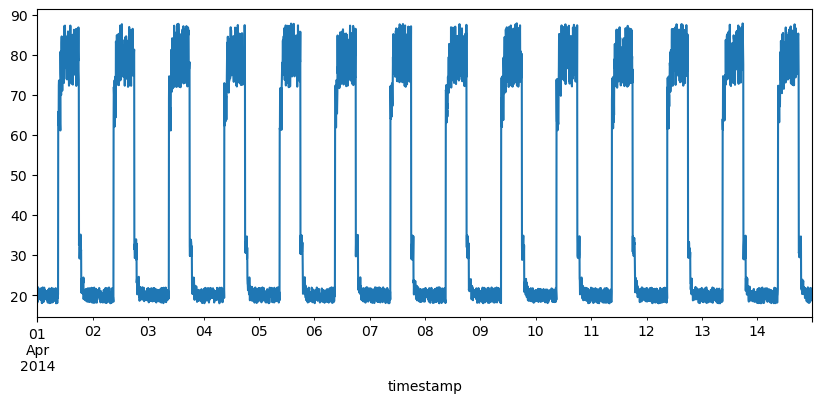

In [5]:
# 
fig, ax = plt.subplots(figsize=(10,4))

# Use pandas to plot data frame.
df_small_noise.plot(legend=False, ax=ax);

In [6]:
#
df_daily_jumpsup = pd.read_csv(with_anomaly_url, parse_dates=True, index_col="timestamp")

In [7]:
# 
df_daily_jumpsup.head()

,value
timestamp,
2014-04-01 00:00:00,19.761252
2014-04-01 00:05:00,20.500833
2014-04-01 00:10:00,19.961641
2014-04-01 00:15:00,21.490266
2014-04-01 00:20:00,20.187739


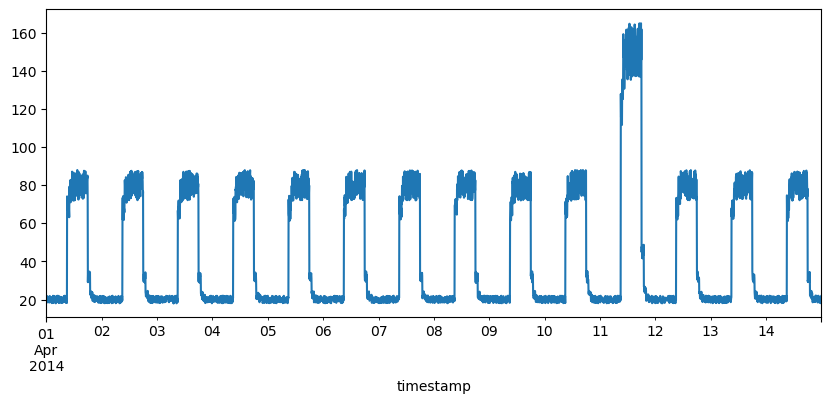

In [8]:
# 
fig, ax = plt.subplots(figsize=(10,4))

# Use pandas to plot data frame.
df_daily_jumpsup.plot(legend=False, ax=ax);

## Preprocessing

***

In [9]:
# 
train_mean = df_small_noise.mean()

train_mean

value    42.438353
dtype: float64

In [10]:
# 
train_std = df_small_noise.std()

train_std

value    28.077122
dtype: float64

In [11]:
# 
df_train_vals = (df_small_noise - train_mean) / train_std

In [12]:
# 
df_train_vals.head()

,value
timestamp,
2014-04-01 00:00:00,-0.858829
2014-04-01 00:05:00,-0.728993
2014-04-01 00:10:00,-0.848148
2014-04-01 00:15:00,-0.729586
2014-04-01 00:20:00,-0.731173


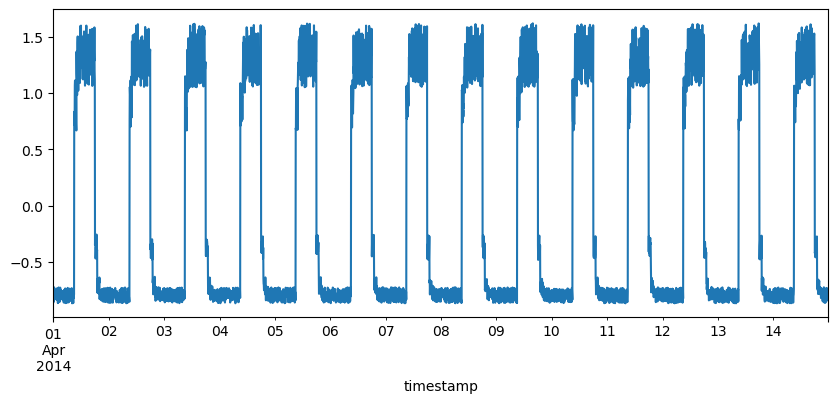

In [13]:
# 
fig, ax = plt.subplots(figsize=(10,4))

# Use pandas to plot data frame.
df_train_vals.plot(legend=False, ax=ax);

In [14]:
# 
df_train_vals.shape

(4032, 1)

In [15]:
# 
df_train_vals.columns

Index(['value'], dtype='object')

In [16]:
# 
window_size = 288

Window example:

```python
[1, 1, 2, 4, 5, 6, 7, 1, 2, 3, 4, 5]
window_size = 3
[1, 1, 2]
[1, 2, 4]
[2, 4, 5]
[4, 5, 6]
```

In [17]:
np.stack([[1, 2, 3], [4, 5, 6], [7, 8, 9], [0, 1, 2]])

array([[1, 2, 3],
       [4, 5, 6],
       [7, 8, 9],
       [0, 1, 2]])

In [18]:
# 
def windows(vals, N=window_size):
  # 
  L = []
  # 
  for i in range(len(vals) - N + 1):
    # 
    L.append(vals[i:i+N])
  # Stack
  return np.stack(L)

In [19]:
# 
x_train = windows(df_train_vals)

In [20]:
# 
x_train[0][0], x_train[0][-1]

(array([-0.85882857]), array([-0.79671155]))

In [21]:
# 
df_train_vals.iloc[0], df_train_vals.iloc[window_size - 1]

(value   -0.858829
 Name: 2014-04-01 00:00:00, dtype: float64,
 value   -0.796712
 Name: 2014-04-01 23:55:00, dtype: float64)

In [22]:
# 
x_train.shape

(3745, 288, 1)

## Neural Network

***

In [23]:
#
layers = [
  #
  keras.layers.Input(shape=(x_train.shape[1], x_train.shape[2])),
  #
  keras.layers.Conv1D(
    filters=32, kernel_size=7, padding="same", strides=2, activation="relu"),
  #
  keras.layers.Dropout(rate=0.2),
  #
  keras.layers.Conv1D(
    filters=16, kernel_size=7, padding="same", strides=2, activation="relu"),
  #
  keras.layers.Conv1DTranspose(
    filters=16, kernel_size=7, padding="same", strides=2, activation="relu"),
  #
  keras.layers.Dropout(rate=0.2),
  #
  keras.layers.Conv1DTranspose(
    filters=32, kernel_size=7, padding="same", strides=2, activation="relu"),
  #
  keras.layers.Conv1DTranspose(filters=1, kernel_size=7, padding="same"),
]

#### Had to install nomkl using the following command: conda install -c conda-forge nomkl

```python

In [24]:
#
model = keras.Sequential(layers)

In [25]:
# 
optimizer = keras.optimizers.Adam(learning_rate=0.001)

In [26]:
# 
model.compile(optimizer=optimizer, loss="mse")

In [27]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 144, 32)           256       
                                                                 
 dropout (Dropout)           (None, 144, 32)           0         
                                                                 
 conv1d_1 (Conv1D)           (None, 72, 16)            3600      
                                                                 
 conv1d_transpose (Conv1DTra  (None, 144, 16)          1808      
 nspose)                                                         
                                                                 
 dropout_1 (Dropout)         (None, 144, 16)           0         
                                                                 
 conv1d_transpose_1 (Conv1DT  (None, 288, 32)          3616      
 ranspose)                                              

In [28]:
# 
history = model.fit(
    x_train,
    x_train,
    epochs=50,
    batch_size=128,
    validation_split=0.1,
    callbacks=[
        keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, mode="min")
    ],
)

Epoch 1/50
27/27 [==============================] - 7s 225ms/step - loss: 0.4590 - val_loss: 0.0593
Epoch 2/50
27/27 [==============================] - 5s 183ms/step - loss: 0.0846 - val_loss: 0.0409
Epoch 3/50
27/27 [==============================] - 5s 176ms/step - loss: 0.0656 - val_loss: 0.0381
Epoch 4/50
27/27 [==============================] - 5s 191ms/step - loss: 0.0549 - val_loss: 0.0311
Epoch 5/50
27/27 [==============================] - 6s 212ms/step - loss: 0.0454 - val_loss: 0.0272
Epoch 6/50
27/27 [==============================] - 5s 201ms/step - loss: 0.0395 - val_loss: 0.0249
Epoch 7/50
27/27 [==============================] - 6s 209ms/step - loss: 0.0353 - val_loss: 0.0233
Epoch 8/50
27/27 [==============================] - 6s 203ms/step - loss: 0.0320 - val_loss: 0.0235
Epoch 9/50
27/27 [==============================] - 6s 205ms/step - loss: 0.0295 - val_loss: 0.0215
Epoch 10/50
27/27 [==============================] - 5s 203ms/step - loss: 0.0273 - val_loss: 0.0241

## Evaluation

***

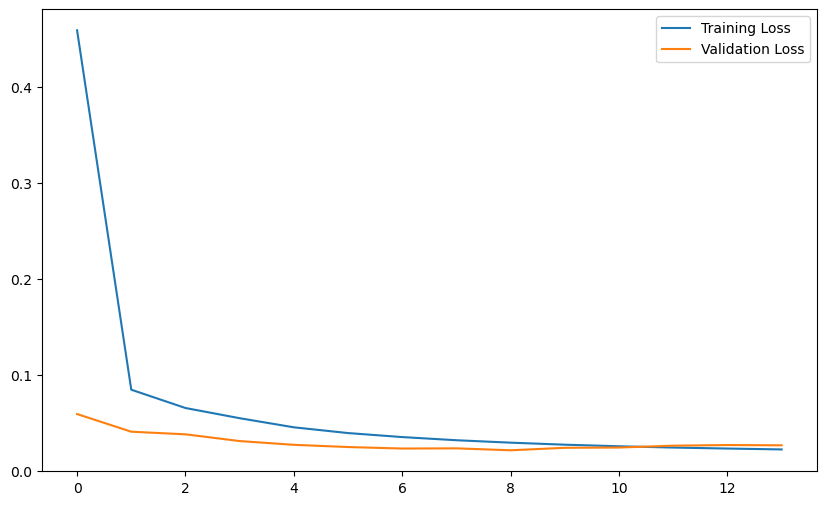

In [29]:
# 
fig, ax = plt.subplots(figsize=(10, 6))
# 
ax.plot(history.history["loss"], label="Training Loss")
# 
ax.plot(history.history["val_loss"], label="Validation Loss")
# 
ax.legend();

In [30]:
# Get train MAE loss.
x_train_pred = model.predict(x_train)

118/118 [==============================] - 1s 3ms/step


In [31]:
# Calculate loss...
train_mae_loss = np.mean(np.abs(x_train_pred - x_train), axis=1)

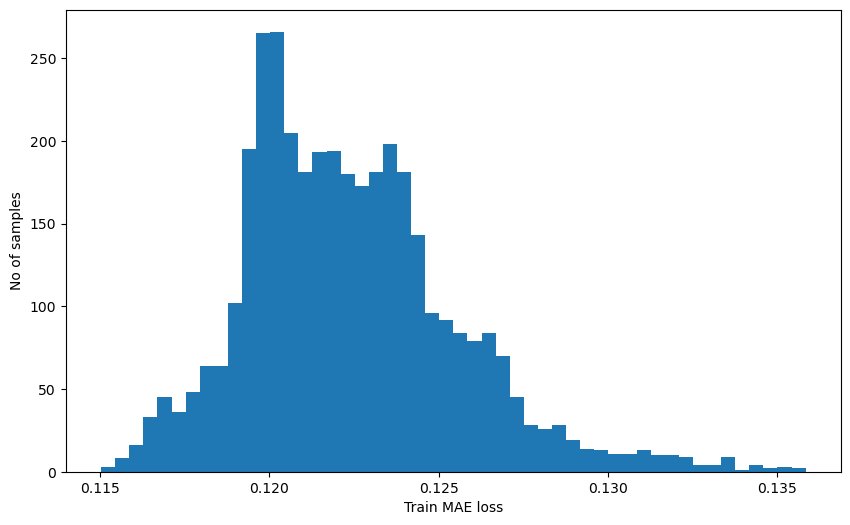

In [32]:
# 
fig, ax = plt.subplots(figsize=(10, 6))
# 
ax.hist(train_mae_loss, bins=50)
# 
ax.set_xlabel("Train MAE loss")
#
ax.set_ylabel("No of samples");

In [33]:
# Get reconstruction loss threshold.
threshold = np.max(train_mae_loss)

# 
threshold

0.13585586593409038

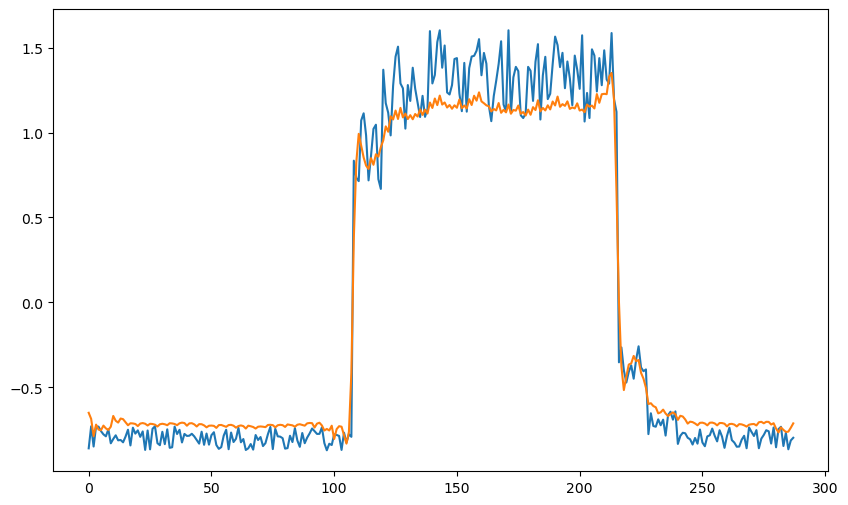

In [34]:
# 
fig, ax = plt.subplots(figsize=(10, 6))

# 
ax.plot(x_train[0])

# 
ax.plot(x_train_pred[0]);

In [35]:
# 
df_test_value = (df_daily_jumpsup - train_mean) / train_std

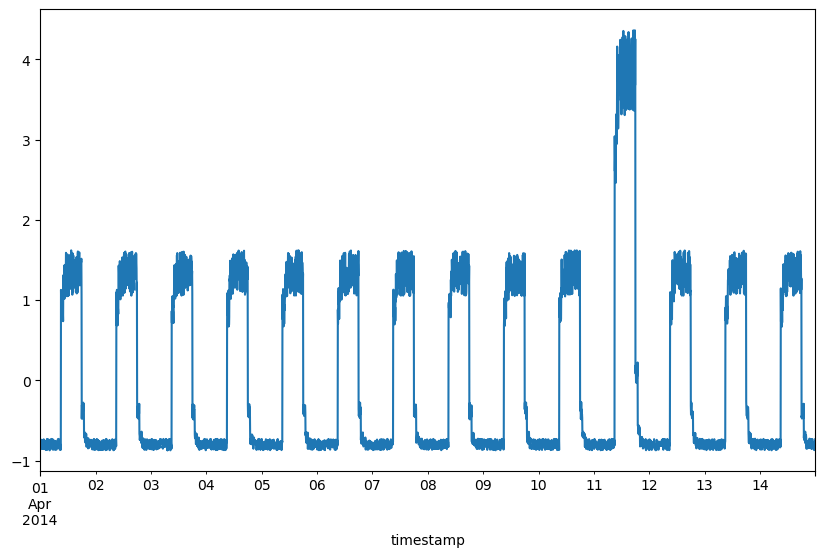

In [36]:
# 
fig, ax = plt.subplots(figsize=(10, 6))

# 
df_test_value.plot(legend=False, ax=ax);

In [37]:
# Create sequences from test values.
x_test = windows(df_test_value.values)

x_test.shape

(3745, 288, 1)

In [38]:
# 
x_test_pred = model.predict(x_test)

118/118 [==============================] - 1s 4ms/step


In [39]:
# 
test_mae_loss = np.mean(np.abs(x_test_pred - x_test), axis=1)

test_mae_loss

array([[0.1182348 ],
       [0.12235065],
       [0.12040408],
       ...,
       [0.11962461],
       [0.12004215],
       [0.11920831]])

In [40]:
# 
test_mae_loss = test_mae_loss.reshape((-1))

test_mae_loss

array([0.1182348 , 0.12235065, 0.12040408, ..., 0.11962461, 0.12004215,
       0.11920831])

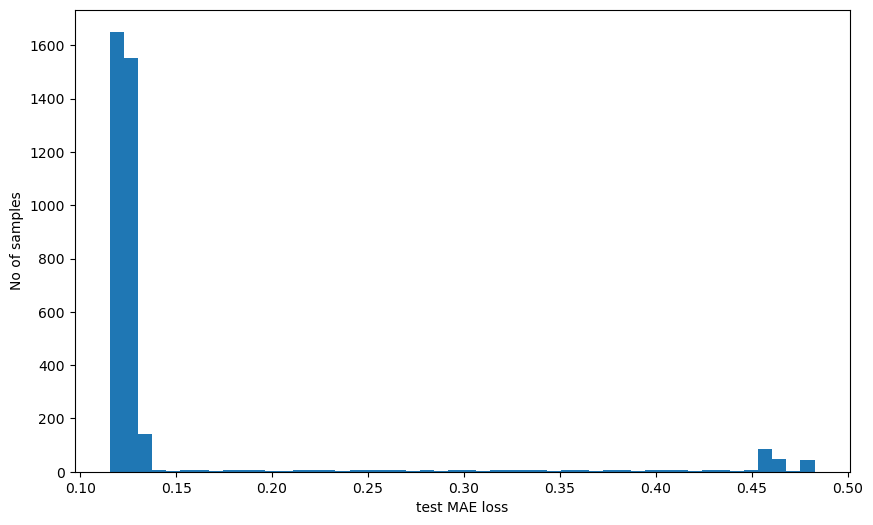

In [41]:
# 
fig, ax = plt.subplots(figsize=(10, 6))

#
ax.hist(test_mae_loss, bins=50)

# 
ax.set_xlabel("test MAE loss")

# 
ax.set_ylabel("No of samples");

In [42]:
# Detect all the samples which are anomalies.
anomalies = test_mae_loss > threshold

# NUmber of anomalies.
np.sum(anomalies)

416

In [43]:
# data i is an anomaly if samples [(i - timesteps + 1) to (i)] are anomalies
inds = []

for i in range(window_size - 1, len(df_test_value) - window_size + 1):
    if np.all(anomalies[i - window_size + 1 : i]):
        inds.append(i)

In [44]:
# 
df_subset = df_daily_jumpsup.iloc[inds]

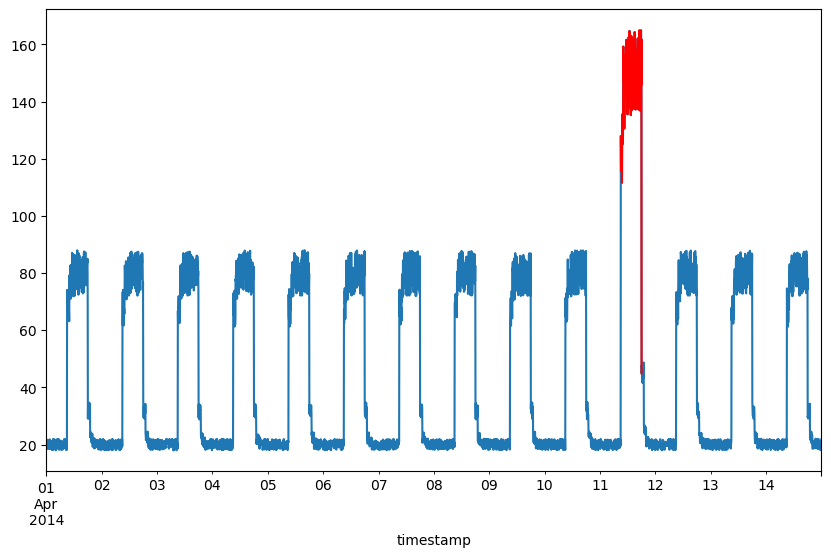

In [45]:
#
fig, ax = plt.subplots(figsize=(10, 6))

# 
df_daily_jumpsup.plot(legend=False, ax=ax)

# 
df_subset.plot(legend=False, ax=ax, color="r");